In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
sampling_freq, audio = wavfile.read('./amicorpus/IB4010/audio/IB4010.Mix-Headset.wav')
wavFile = './amicorpus/IB4010/audio/IB4010.Mix-Headset.wav'
print( '\nShape:', audio.shape)
print ('Datatype:', audio.dtype)
print ('Duration:', round(audio.shape[0] / float(sampling_freq),3), 'seconds')


Shape: (47368875,)
Datatype: int16
Duration: 2960.555 seconds


In [8]:
import librosa
import numpy as np
import soundfile as sf

# load audio file
audio_file, sr = librosa.load("./amicorpus/IB4010/audio/IB4010.Mix-Headset.wav", sr=16000)

# set parameters for voice activity detection
frame_length = int(sr*0.02) # 20ms
hop_length = int(sr*0.01) # 10ms
threshold_ratio = 1.5

# calculate energy of each frame
energy = librosa.feature.rms(y = audio_file, frame_length=frame_length, hop_length=hop_length)[0]

# calculate a threshold for voice activity detection
threshold = np.mean(energy) * threshold_ratio

# create an array to store the voice activity labels
vad_labels = np.zeros_like(energy)

# set frames with energy above the threshold as active
vad_labels[energy > threshold] = 1

# print the voice activity labels
print(vad_labels)
cnt = 0
i = 0
while(i < len(vad_labels)):
    if(vad_labels[i]==1):
        cnt+=1
    i+=1
print(cnt)
print(vad_labels.shape[0])

[0. 0. 0. ... 0. 0. 0.]
67777
296056


16000


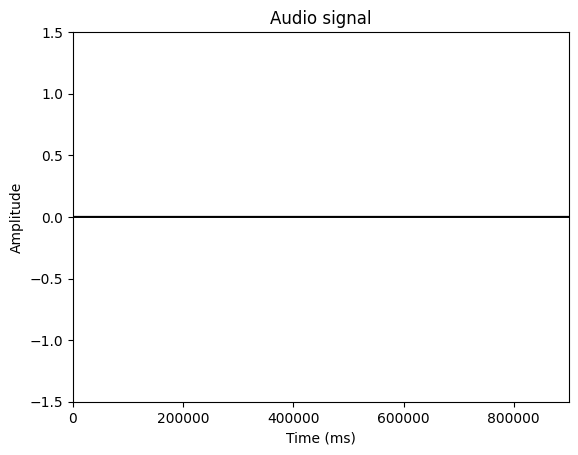

In [7]:
print(sampling_freq)
audio=audio/2.**15
audio=audio[:]
x_values = np.arange(0, len(audio), 1)/ float(sampling_freq)
x_values *= 1000
plt.plot(x_values, audio, color='black')
plt.xlim(-1,900000)
plt.ylim(-1.5,1.5)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Audio signal')
plt.show()

In [43]:
segLen,frameRate,numMix = 3,50,128
def VoiceActivityDetection(wavData, frameRate):
    # uses the librosa library to compute short-term energy
    ste = librosa.feature.rms(y = wavData,hop_length=int(16000/frameRate)).T
    thresh = 0.1*(np.percentile(ste,97.5) + 9*np.percentile(ste,2.5))    # Trim 5% off and set threshold as 0.1x of the ste range
    return (ste>thresh).astype('bool')

In [18]:
import os
import pickle
import warnings
import librosa
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import *
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf

wavData,_ = librosa.load(wavFile,sr=16000)
mfcc = librosa.feature.mfcc(sr = sampling_freq,y = audio,n_mfcc=20).T
#vad = VoiceActivityDetection(wavData, 16000)
vad = np.reshape(vad_labels,(len(vad_labels),))
if mfcc.shape[0] > vad.shape[0]:
    vad = np.hstack((vad,np.zeros(mfcc.shape[0] - vad.shape[0]).astype('bool'))).astype('bool')
elif mfcc.shape[0] < vad.shape[0]:
    vad = vad[:mfcc.shape[0]]
    mfcc = mfcc[:len(vad)-1,:]

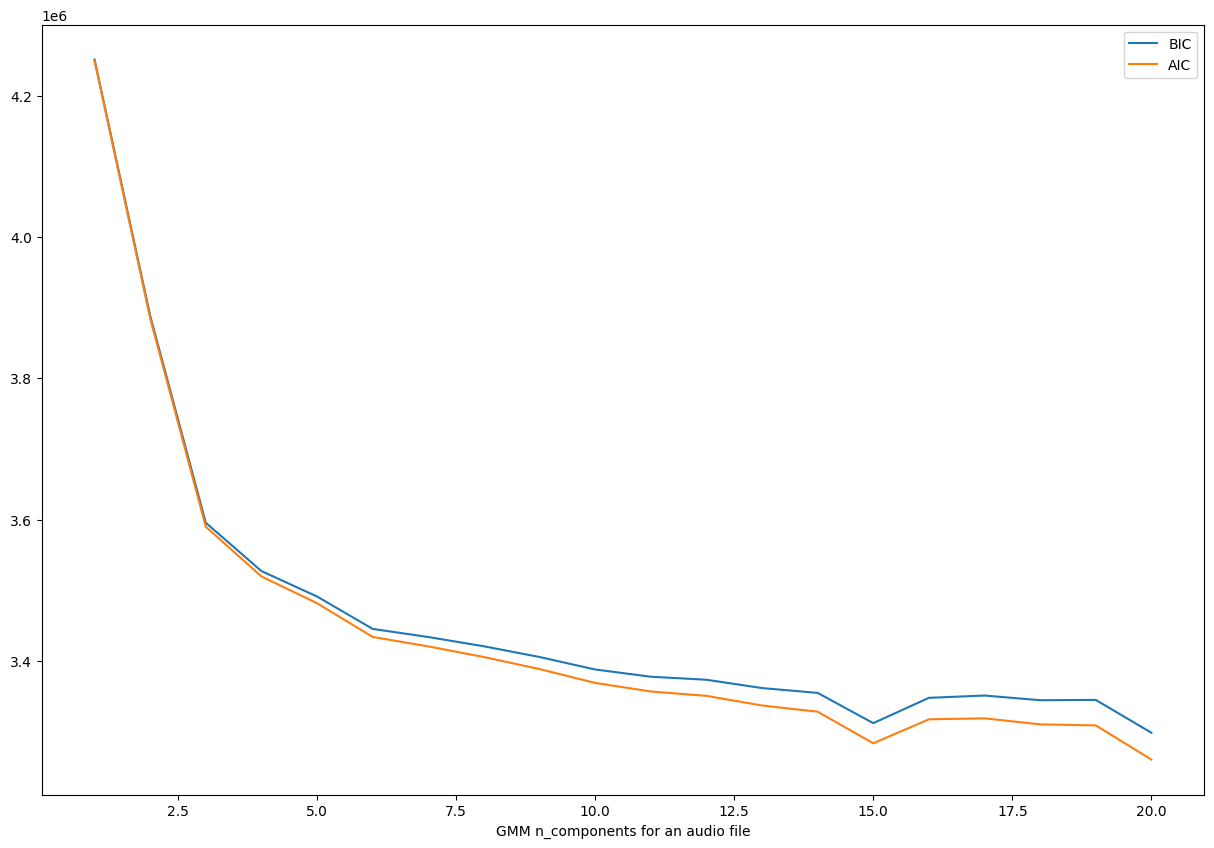

In [21]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0, max_iter = 1000).fit(mfcc)
          for n in n_components]

plt.figure(figsize=(15, 10))
plt.plot(n_components, [m.bic(mfcc) for m in models], label='BIC')
plt.plot(n_components, [m.aic(mfcc) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('GMM n_components for an audio file');

In [27]:
GMM = GaussianMixture(n_components=128,covariance_type='diag',max_iter=1000).fit(mfcc)
var_floor = 1e-5
frameRate = 20
segLikes = []
segLen = 3
segSize = frameRate*segLen
for segI in range(int(np.ceil(float(mfcc.shape[0])/(frameRate*segLen)))):
        startI = segI*segSize
        endI = (segI+1)*segSize
        if endI > mfcc.shape[0]:
            endI = mfcc.shape[0]-1
        if endI==startI:    # Reached the end of file
            break
        seg = mfcc[startI:endI,:]
        compLikes = np.sum(GMM.predict_proba(seg),0)
        segLikes.append(compLikes/seg.shape[0])
print("Training Done")
print(np.asarray(segLikes))

Training Done
[[1.16790149e-18 1.00142958e-05 2.42270875e-02 ... 2.58630762e-06
  4.90802561e-05 2.20640534e-06]
 [7.22439922e-13 1.28925568e-06 2.84845514e-02 ... 3.18467738e-24
  2.55774482e-05 8.19567983e-09]
 [3.44151648e-87 1.43679861e-02 3.56635511e-02 ... 7.43648571e-18
  2.78183976e-02 1.78768862e-04]
 ...
 [6.46544704e-56 6.00314736e-02 1.17677755e-01 ... 7.78512498e-04
  2.68518884e-03 1.50086563e-05]
 [3.22312202e-08 2.11388951e-05 1.28339351e-02 ... 4.63235067e-16
  3.34490272e-03 8.36731412e-08]
 [2.90101150e-25 1.13736593e-16 4.76616301e-03 ... 5.48844851e-24
  4.42962858e-06 2.76972390e-10]]


In [32]:
cnt = 0
for i in range(len(segLikes)):
    print(segLikes[i].max())
    cnt+=1
#print(np.asarray(segLikes).max())
print(cnt)

0.07651400556714504
0.1429547362531409
0.10743250848224066
0.13503786773076684
0.1169014147163592
0.46467862267082183
0.16570864630251209
0.21982413714816226
0.19707636909316822
0.19315934510338773
0.1897244028457065
0.28646754215690146
0.25359190289041905
0.3222573656888015
0.11215958151093101
0.10470512719728857
0.10398583313087312
0.09670194531214762
0.17358816557952744
0.12245938441750413
0.19736139672025846
0.14248658935723996
0.19142738282772193
0.1900097058944115
0.18743473216584527
0.20228594359676405
0.1312868749915499
0.24265554898233682
0.15638989422285945
0.1290666526039455
0.1737592078303942
0.11825980480781403
0.12822357810050822
0.13762673621934696
0.179623408278439
0.24428260732095206
0.2719895651116582
0.16659913865823606
0.1254237969729613
0.22506660802691453
0.12621636741608885
0.10058803159634491
0.14177889409066508
0.10999090477366331
0.08393133627876417
0.12263124673498854
0.09572866550428695
0.1156959467074976
0.1336347788496664
0.06704681826946746
0.112133157470